## Open notebook in:
| Colab                               Gradient                                                                                                                                         |
|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nicolepcx/Transformers-in-Action/blob/main/CH06/ch06_Qwen_RAG_Multimodal_Notebook.ipynb)                                              

# About the Notebook

This notebook demonstrates a **multimodal pipeline** for automated **table detection**, **text extraction**, **document comparison**, and **retrieval-augmented generation (RAG)** using a combination of:

* **OpenAI GPT-4o** for multimodal understanding (text and image inputs)
* **LlamaIndex** for building and querying vector-based indexes across text and images
* **Qdrant** as the vector store backend
* **CLIP** embeddings for visual similarity retrieval
* **Table Transformer** (from Microsoft) for accurate table detection and structure recognition
* **EasyOCR** and PyMuPDF for document conversion and OCR

##Key Capabilities

1. **PDF Preprocessing**

   * Downloads a technical report (e.g., Qwen3 from arXiv)
   * Converts each page to high-resolution PNG images
   * Saves pages in numerically ordered filenames for consistent indexing

2. **Multimodal Indexing with LlamaIndex + Qdrant**

   * Creates a **MultiModalVectorStoreIndex** over document images
   * Enables **text-to-image retrieval** using CLIP embeddings
   * Retrieves most relevant figures or tables based on natural language queries

3. **Image-to-Text Reasoning via GPT-4o**

   * Passes selected image regions or full pages to GPT-4o
   * Extracts structured content (e.g., tables in JSON format) or high-level summaries
   * Compares visual content from technical documents (e.g., Qwen2.5 vs Qwen3)

4. **Object Detection & Table Cropping**

   * Uses Microsoft’s Table Transformer to detect table bounding boxes
   * Automatically crops and saves table regions
   * Prepares cropped images for detailed multimodal querying

5. **Semantic Search over Extracted Text**

   * Extracts text from GPT-4o outputs and indexes them
   * Supports follow-up queries using traditional **text-based retrieval**
   * Enables hybrid multimodal + textual search

## Stack Used

| Component            | Purpose                                |
| -------------------- | -------------------------------------- |
| `LlamaIndex`         | Index construction and retrieval logic |
| `Qdrant`             | Vector database for image/text chunks  |
| `OpenAI GPT-4o`      | Vision-language understanding          |
| `CLIP` Embeddings    | Image similarity search                |
| `Table Transformer`  | Object detection for tables            |
| `PyMuPDF` + `PIL`    | PDF-to-image conversion                |
| `EasyOCR` (optional) | Text recognition from image regions    |
| `Matplotlib`         | Visualization and inspection           |


Note: You need to set the .env via Terminal in your Google Colab via:

```
cat <<EOL > .env
OPENAI_API_KEY="YOUR_API_KEY"
EOL```

## Install Dependencies

In [ ]:
%%capture
!pip install -q llama-index==0.12.50 \
                qdrant_client==1.15.0 \
                pyMuPDF==1.26.3 tools==1.0.2 \
                frontend git+https://github.com/openai/CLIP.git \
                easyocr==1.7.2 \
                llama-index-vector-stores-qdrant==0.6.1 \
                llama-index-embeddings-clip==0.4.0 \
                python-dotenv==1.0.1

# Restart kernel via JS
import IPython
from IPython.display import display, Javascript

def restart_colab_kernel():
    display(Javascript("google.colab.kernel.restart()"))

restart_colab_kernel()


# Imports

In [ ]:
# Imports for API
from dotenv import load_dotenv
import os

load_dotenv()

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

In [ ]:
# Standard Library
import io
import re
import csv
import glob
import base64
from pathlib import Path
import subprocess

# Third-Party Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch
from PIL import Image, ImageDraw, Image as PILImage
import fitz  # PyMuPDF
import torch
import easyocr
from torch import Tensor

# Transformers & TorchVision
from transformers import AutoModelForObjectDetection
from torchvision import transforms

# OpenAI
from openai import OpenAI

# Qdrant
import qdrant_client

# LlamaIndex Core
from llama_index.core import (
    ServiceContext,
    SimpleDirectoryReader,
    VectorStoreIndex,
    StorageContext,
)
from llama_index.core.schema import (
    ImageDocument,
    ImageNode,
    Document,
)
from llama_index.core.response.notebook_utils import display_source_node

# LLMs LlamaIndex
from llama_index.llms.openai import OpenAI as OpenAIIndex

# LlamaIndex Multimodal & Qdrant
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core.indices.multi_modal.retriever import (
    MultiModalVectorIndexRetriever,
)
from llama_index.vector_stores.qdrant import QdrantVectorStore

# Typing
from typing import Tuple, Union, List, Dict, Any




In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Downloads the Qwen3 technical report from arXiv using wget and saves it locally for further processing.

In [ ]:
# Download the Qwen3 Technical Report as PDF
pdf_url = "https://arxiv.org/pdf/2505.09388.pdf"
pdf_filename = "Qwen3.pdf"

# Use wget to download with user-agent set
subprocess.run([
    "wget", "--user-agent", "Mozilla", pdf_url, "-O", pdf_filename
], check=True)

# Confirm download
os.path.exists(pdf_filename)


True

Converts each page of the PDF to a `.png` image using PyMuPDF. Filenames are zero-padded for correct ordering.

In [ ]:

PDF_PATH = "Qwen3.pdf"

# Use the uploaded file path
uploaded_pdf_path = Path(PDF_PATH)
output_dir = uploaded_pdf_path.stem

# Create output directory
output_path = Path(f"{output_dir}")
output_path.mkdir(parents=True, exist_ok=True)

# Open and convert PDF pages to images
pdf_document = fitz.open(str(uploaded_pdf_path))
total_pages = pdf_document.page_count

# Determine padding width based on total pages
pad_width = len(str(total_pages))

# Save pages with zero-padded numbering
for page_number in range(total_pages):
    page = pdf_document[page_number]
    pix = page.get_pixmap()
    image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    filename = f"page_{str(page_number + 1).zfill(pad_width)}.png"
    image.save(output_path / filename)
pdf_document.close()

# List and sort the image paths
image_paths_sorted = sorted(output_path.glob("page_*.png"))

# Display first few image paths
image_paths_sorted[:5]


[PosixPath('Qwen3/page_01.png'),
 PosixPath('Qwen3/page_02.png'),
 PosixPath('Qwen3/page_03.png'),
 PosixPath('Qwen3/page_04.png'),
 PosixPath('Qwen3/page_05.png')]

Ensures the image files are numerically sorted by page number using a regex helper.

In [ ]:
# Helper: extract numeric page number
def extract_page_number(path: Union[str, Path]) -> Union[int, float]:
    path = Path(path)  # Ensure it's a Path object
    match = re.search(r'page_(\d+)\.png', path.name)
    return int(match.group(1)) if match else float('inf')

# Sort based on actual numeric page number
image_paths_sorted_numeric: List[Path] = sorted(image_paths_sorted, key=extract_page_number)

# Display the first few sorted paths numerically
image_paths_sorted_numeric[:5]


[PosixPath('Qwen3/page_01.png'),
 PosixPath('Qwen3/page_02.png'),
 PosixPath('Qwen3/page_03.png'),
 PosixPath('Qwen3/page_04.png'),
 PosixPath('Qwen3/page_05.png')]

Displays a sample of PDF page images (e.g., pages 6–10) for visual verification.

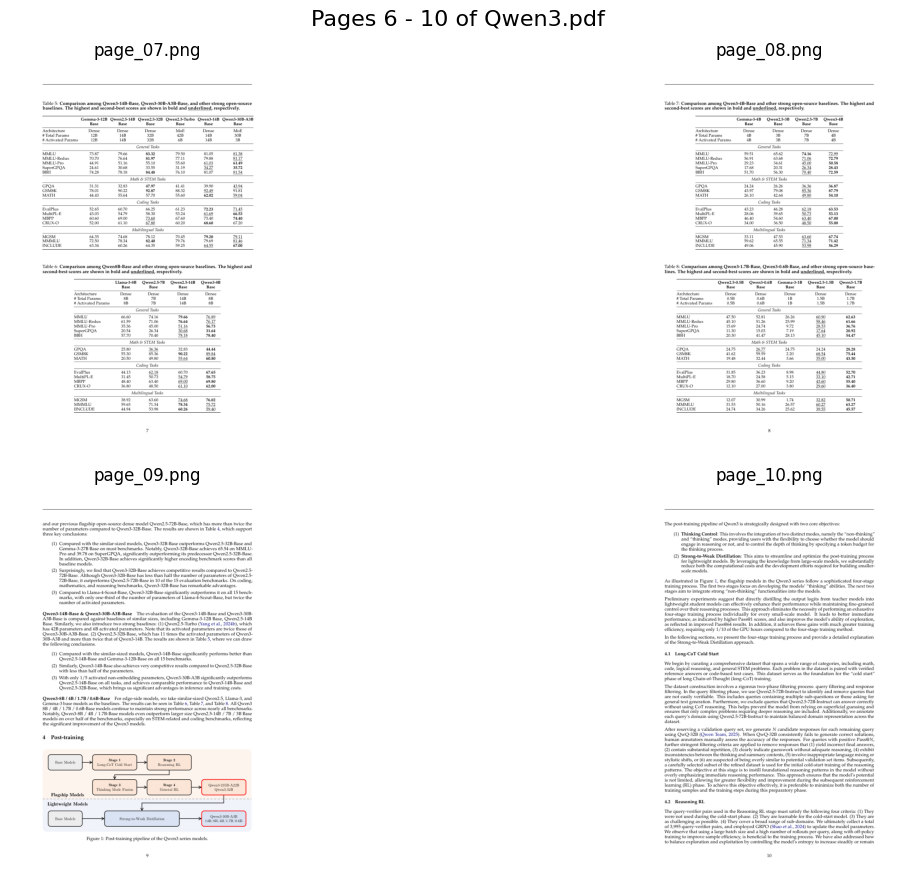

In [ ]:

# Plot the first 4 images for visual verification
def plot_images(image_paths, title="Sample PDF Pages"):
    plt.figure(figsize=(16, 9))
    for idx, img_path in enumerate(image_paths[6:10]):
        img = Image.open(img_path)
        plt.subplot(2, 2, idx + 1)
        plt.imshow(img)
        plt.title(img_path.name)
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

plot_images(image_paths_sorted_numeric, title="Pages 6 - 10 of Qwen3.pdf")


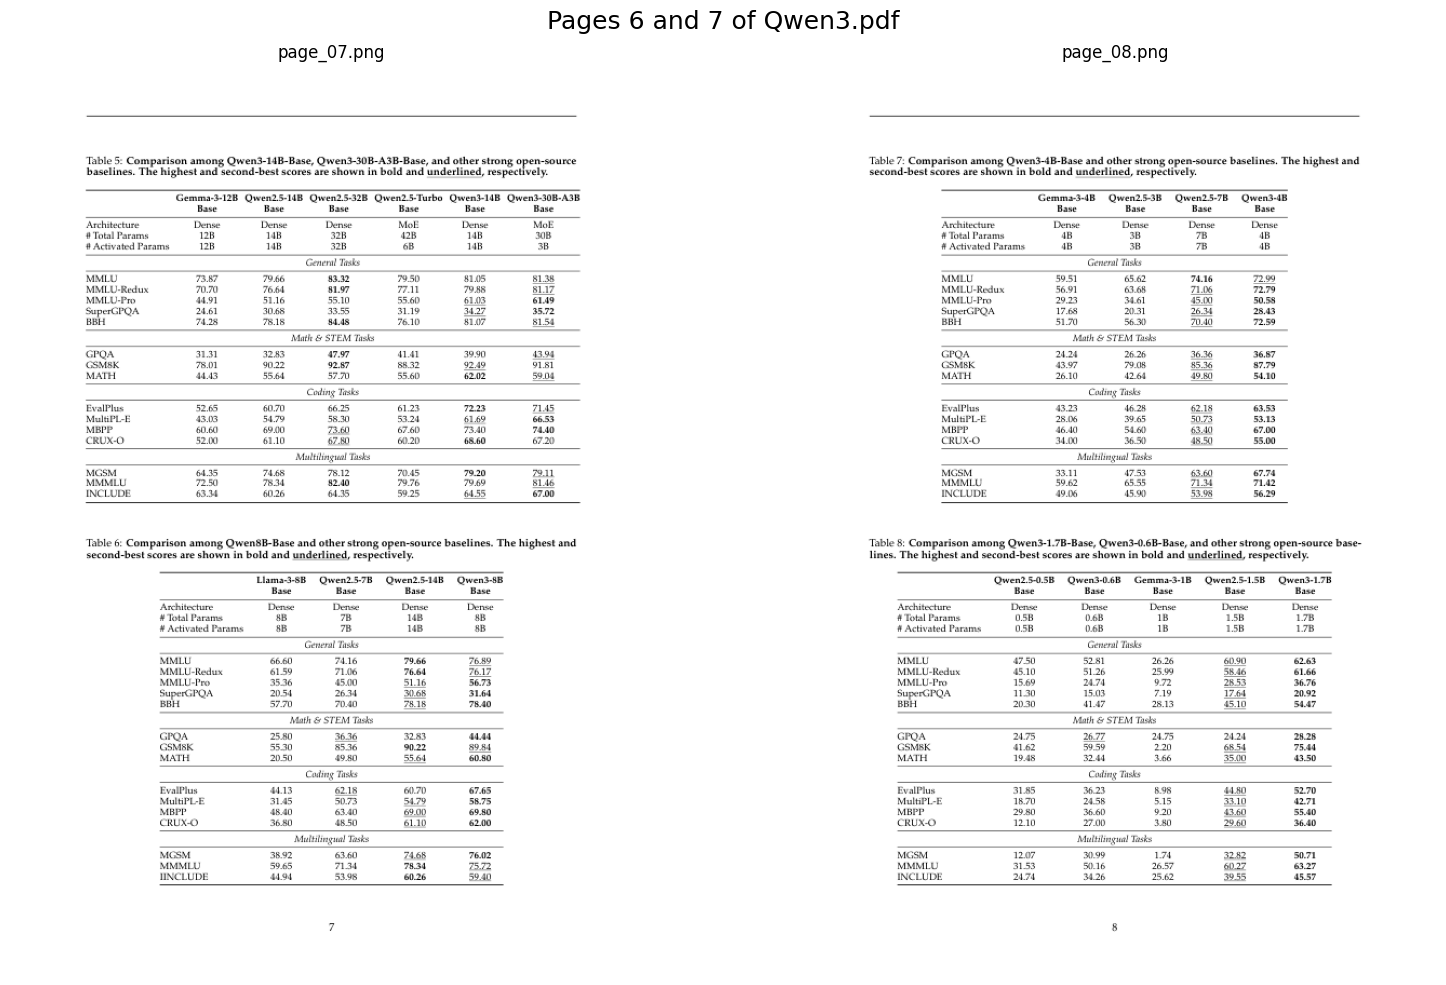

In [ ]:
# Plot 2 sample pages side by side at larger scale
def plot_two_pages(image_paths, title="Sample PDF Pages"):
    plt.figure(figsize=(16, 10))  # wider and taller
    for idx, img_path in enumerate(image_paths[:2]):  # just first 2 pages for example
        img = Image.open(img_path)
        plt.subplot(1, 2, idx + 1)  # 1 row, 2 columns
        plt.imshow(img)
        plt.title(img_path.name, fontsize=12)
        plt.axis("off")
    plt.suptitle(title, fontsize=18)
    plt.tight_layout()
    plt.show()

# Example: show pages 6 and 7 side by side
plot_two_pages(image_paths_sorted_numeric[6:8], title="Pages 6 and 7 of Qwen3.pdf")


Loads the image files into `ImageDocument` objects for multimodal indexing.

In [ ]:
# Read the images
documents_images = SimpleDirectoryReader("./Qwen3/").load_data()

# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_index")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

# Create the MultiModal index
index = MultiModalVectorStoreIndex.from_documents(
    documents_images,
    storage_context=storage_context,
)

retriever_engine = index.as_retriever(image_similarity_top_k=2)

100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 90.1MiB/s]
/usr/local/lib/python3.11/dist-packages/llama_index/vector_stores/qdrant/base.py:709: UserWarning: Payload indexes have no effect in the local Qdrant. Please use server Qdrant if you need payload indexes.
  self._client.create_payload_index(


In [ ]:
query = "Compare Qwen2.5 with Qwen3."
assert isinstance(retriever_engine, MultiModalVectorIndexRetriever)
# retrieve for the query using text to image retrieval
retrieval_results = retriever_engine.text_to_image_retrieve(query)

In [ ]:
def plot_images(image_paths, title="Retrieved Images"):
    plt.figure(figsize=(15, 6))
    for idx, img_path in enumerate(image_paths[:10]):
        img = Image.open(img_path)
        plt.subplot(2, 5, idx + 1)
        plt.imshow(img)
        plt.title(Path(img_path).name)  # convert str to Path
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


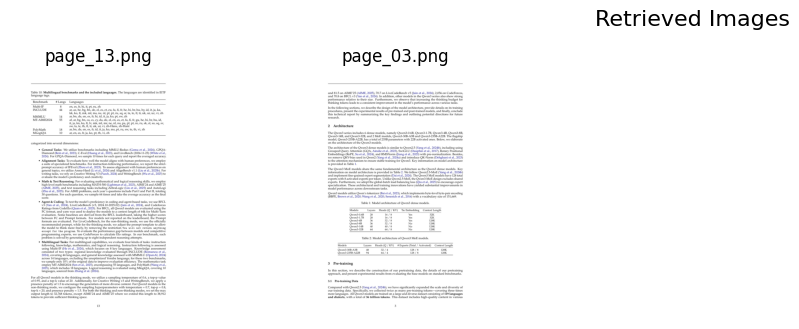

In [ ]:
retrieved_images = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_images.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_images)

In [ ]:
image_documents = [
    ImageDocument(image_path=image_path) for image_path in retrieved_images
]

In [ ]:
from openai import OpenAI
client = OpenAI(api_key=OPENAI_API_KEY)

# Convert all images to base64 and add to messages
messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Compare Qwen2.5 with Qwen3 using these images:"},
        ] + [
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/png;base64,{base64.b64encode(open(img, 'rb').read()).decode()}"
                },
            }
            for img in retrieved_images
        ],
    }
]

response = client.chat.completions.create(
    model="gpt-4o",
    messages=messages,
    max_tokens=500
)

print(response.choices[0].message.content)


Based on the images provided, here are some key differences between Qwen2.5 and Qwen3:

### Multilingual Capabilities
- **Qwen2.5:** Covers fewer languages and has a lower token count in pretraining datasets.
- **Qwen3:** Includes a broader range of languages (19 languages and dialects) and significantly more pretraining data (36 trillion tokens), improving multilingual understanding.

### Architecture
- **Qwen2.5:** Uses models with fewer parameters and experts, employing previous architectural components.
- **Qwen3:** Features six dense models and two MoE models with significantly more parameters and activated experts per token. It incorporates advanced components like Grouped Query Attention and residual pre-normalization, enhancing performance.

### Pre-training
- **Qwen2.5:** Uses less pretraining data and fewer training tokens.
- **Qwen3:** Trained on a vastly larger and more diverse dataset, potentially boosting generalization and specific task performance.

### Model Performanc

In [ ]:
documents_images_v2 = SimpleDirectoryReader("/content/Qwen3").load_data()

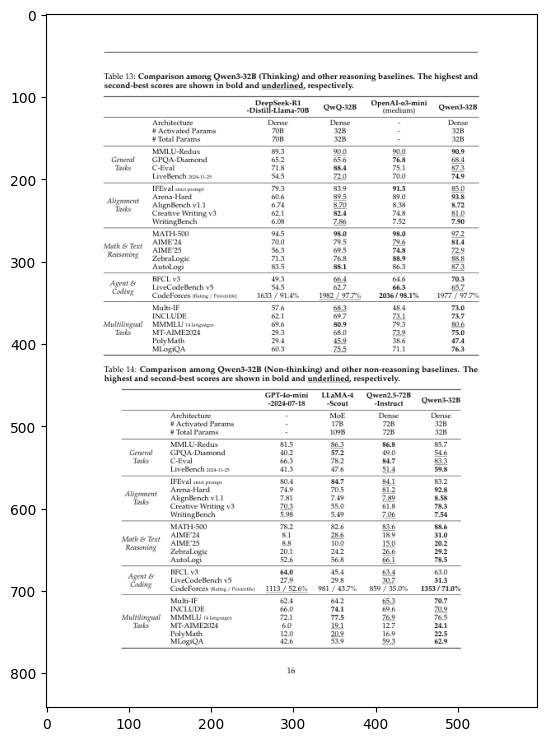

In [ ]:
image = Image.open(documents_images_v2[15].image_path).convert("RGB")

plt.figure(figsize=(16, 9))
plt.imshow(image)

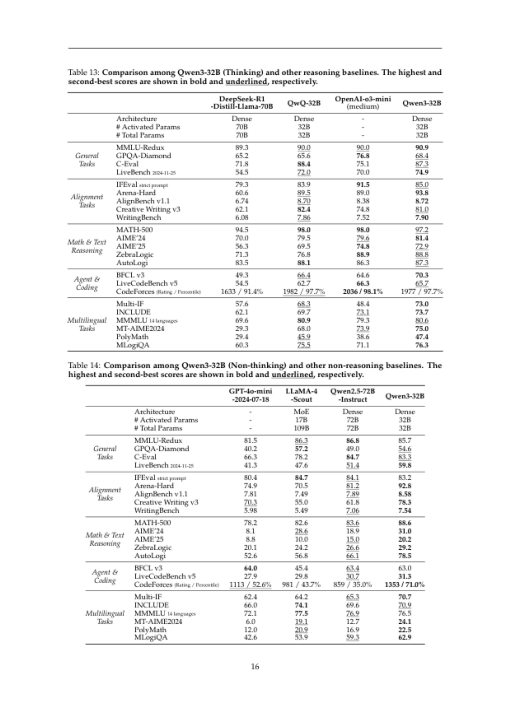

Here's the JSON representation of the tables extracted from the image:

```json
{
  "Table 13": {
    "DeepSeck-R1 (Distill-LLaMA-70B)": {
      "# Activated Params": "70B",
      "# Total Params": "70B",
      "MMUL-Redux": 89.3,
      "GQA-Diamond": 65.2,
      "C-Eval": 71.8,
      "LiveBench 2024-HS": 54.5,
      "HF\nfeat and prompt": 79.3,
      "Arena-Hard": 60.6,
      "AlignBench v1.1": 6.74,
      "Creative Writing v3": 6.21,
      "WritingBench": 6.08,
      "MATH-500": 94.5,
      "AIME-25": 70.0,
      "AMC12": 56.3,
      "ZebraLogic": 71.3,
      "AutoLogi": 83.5,
      "BFC v3": 93.3,
      "LiveCodeBench v5": 54.5,
      "CodeForces (Rating / Percentile)": "1633 / 91.4%"
    },
    "QwQ-32B": {
      "# Activated Params": "32B",
      "# Total Params": "32B",
      "MMUL-Redux": 90.4,
      "GQA-Diamond": 65.6,
      "C-Eval": 85.4,
      "LiveBench 2024-HS": 72.4,
      "HF\nfeat and prompt": 83.9,
      "Arena-Hard": 89.5,
      "AlignBench v1.1": 8.70,
      "Creati

In [ ]:

client = OpenAI(api_key=OPENAI_API_KEY)

# Pick one image from your documents
image_path = documents_images_v2[15].image_path

# Visualize
image = Image.open(image_path).convert("RGB")
plt.figure(figsize=(16, 9))
plt.imshow(image)
plt.axis('off')
plt.show()

# Prompt
image_prompt = """
Please load the table data and output it in JSON format from the image.
Try your best to extract the table data from the image.
If you can't extract the table data, summarize the image instead.
"""

# Base64 encode image
with open(image_path, "rb") as f:
    image_bytes = f.read()
    image_b64 = base64.b64encode(image_bytes).decode("utf-8")

# Call GPT-4o with multimodal message
response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": image_prompt.strip()},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/png;base64,{image_b64}"},
                },
            ],
        }
    ],
    max_tokens=1500,
)

# Output result
print(response.choices[0].message.content)


In [ ]:

# Helper: extract page number from path
def extract_page_number(doc):
    match = re.search(r'page_(\d+)\.png', doc.image_path)
    return int(match.group(1)) if match else float('inf')  # fallback pushes errors to end

# Sort documents by page number
documents_images_v2_sorted = sorted(documents_images_v2, key=extract_page_number)

# Limit to first N sorted images
N = 10
documents_subset = documents_images_v2_sorted[:N]

# Now continue as before...
image_results = {}

for idx, img_doc in enumerate(documents_subset, start=1):
    print(f"🔄 Processing image {idx}/{N}: {img_doc.image_path}")

    try:
        with open(img_doc.image_path, "rb") as f:
            image_bytes = f.read()
            image_b64 = base64.b64encode(image_bytes).decode("utf-8")

        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": image_prompt.strip()},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{image_b64}"
                        },
                    },
                ],
            }
        ]

        response = client.chat.completions.create(
            model="gpt-4o",
            messages=messages,
            max_tokens=1500,
        )

        result_text = response.choices[0].message.content
        image_results[img_doc.image_path] = result_text

    except Exception as e:
        print(f"❌ Error on image {idx}/{N}: {img_doc.image_path} — {str(e)}")
        continue

print(f"\n✅ Done processing {len(image_results)} out of {N} images.")


🔄 Processing image 1/10: /content/Qwen3/page_01.png
🔄 Processing image 2/10: /content/Qwen3/page_02.png
🔄 Processing image 3/10: /content/Qwen3/page_03.png
🔄 Processing image 4/10: /content/Qwen3/page_04.png
🔄 Processing image 5/10: /content/Qwen3/page_05.png
🔄 Processing image 6/10: /content/Qwen3/page_06.png
🔄 Processing image 7/10: /content/Qwen3/page_07.png
🔄 Processing image 8/10: /content/Qwen3/page_08.png
🔄 Processing image 9/10: /content/Qwen3/page_09.png
🔄 Processing image 10/10: /content/Qwen3/page_10.png

✅ Done processing 10 out of 10 images.


In [ ]:
text_docs = [
    Document(
        text=str(image_results[image_path]),
        metadata={"image_path": image_path},
    )
    for image_path in image_results
]

In [ ]:
# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_mm_db_Qwen3")

llama_text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)

storage_context = StorageContext.from_defaults(vector_store=llama_text_store)

# Create the Text Vector index
index = VectorStoreIndex.from_documents(
    text_docs,
    storage_context=storage_context,
)

In [ ]:
MAX_TOKENS = 50
retriever_engine = index.as_retriever(
    similarity_top_k=3,
)
# Retrieve more information from the GPT4o response
retrieval_results = retriever_engine.retrieve("Compare Qwen2.5 with Qwen3")

In [ ]:
retrieved_image = []
for res_node in retrieval_results:
    display_source_node(res_node, source_length=1000)

**Node ID:** 32352f0d-83b6-4965-adff-18925fcb5ed4<br>**Similarity:** 0.8366009728388631<br>**Text:** The image contains text discussing the evaluation of the Qwen-3 series base models compared to other models. It includes details about coding tasks (like EvalPlus and MBPP) and multilingual tasks (such as MCSM and MMMLU).

Key points in the summary:

1. The Qwen-3 series models outperform other models like Llama-4, Qwen-2.5 Base, especially in terms of fewer parameters while maintaining performance.
2. Inference and training costs are improved with Qwen's models.
3. The Qwen's base models offer comparable performance at higher parameter scales, with specific improvements in benchmarks involving reasoning, language, and STEM.

Two main versions are highlighted:

- **Qwen3-235B-A22B-Base**: Outperforms other open-source base models, achieving the best performance in most evaluated benchmarks.
- **Qwen3-32B-Base**: Largest dense model in the Qwen-3 series, also compared with other baselines.

These models bring significant advantages in efficiency and cost-effectiveness.<br>

**Node ID:** 64b01f13-5bb4-43de-aef4-c8104efdaccf<br>**Similarity:** 0.7838149190210569<br>**Text:** The image contains a textual document without any tables. Here’s a brief summary:

The document discusses the pursuit of artificial general intelligence (AGI) and introduces Qwen, a series of open-weight large language models (LLMs) for advancing AI capabilities. The models utilize vast datasets and exhibit strong reasoning and performance across various tasks and domains. Qwen3 is highlighted, with the flagship model Qwen3-235B-A2B being a Mixture-of-Experts (MoE) model. There is an emphasis on improving reasoning and thinking modes, model usability, multilingual capabilities, and innovative training approaches. The document also mentions the evaluation of both pre-trained and post-trained versions of the models.<br>

**Node ID:** 1d57c490-1d72-47cb-8783-1be73a249aa5<br>**Similarity:** 0.7747033470287674<br>**Text:** The image is a page from a technical report about "Qwen3," a large language model. Here's a summary:

- **Title**: Qwen3 Technical Report
- **Team**: Qwen Team
- **Links**: 
  - https://huggingface.co/Qwen
  - https://modelscope.cn/organization/qwen
  - http://github.com/QwenLM/Qwen3
- **Abstract**: The report introduces Qwen3, the latest version of the Qwen model family. It highlights the integration of thinking and non-thinking modes for complex and rapid responses. The new model eliminates the need to switch between different models and introduces a thinking budget mechanism to optimize resource use. Qwen3 supports 119 languages/dialects, up from 29, and aims to enhance global accessibility. All models are available under Apache 2.0.

There is no table data in the image to extract.<br>

In [ ]:
query_engine = index.as_query_engine()
query_engine.query("Compare Qwen2.5 with Qwen3")

Response(response='Qwen3 models outperform Qwen2.5 models, especially in terms of efficiency and cost-effectiveness. Qwen3 models offer improved performance in various benchmarks involving reasoning, language, and STEM, while maintaining comparable performance at higher parameter scales. Additionally, Qwen3 models have shown advancements in inference and training costs, making them a more efficient choice compared to Qwen2.5 models.', source_nodes=[NodeWithScore(node=TextNode(id_='32352f0d-83b6-4965-adff-18925fcb5ed4', embedding=None, metadata={'image_path': '/content/Qwen3/page_05.png'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='6ea29aee-405a-485a-9a84-2ac57ed28291', node_type='4', metadata={'image_path': '/content/Qwen3/page_05.png'}, hash='f8e21155f0f00340adf9989e10d92c5a57d16ae8d4c3af211f049199bfc32655')}, metadata_template='{key}: {value}', metadata_separator='\n', text="The image contain

Detects bounding boxes of tables, crops them from full-page images, and saves them for further analysis.

In [ ]:
class MaxResize(object):
    def __init__(self, max_size: int = 800) -> None:
        self.max_size = max_size

    def __call__(self, image: PILImage.Image) -> PILImage.Image:
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize(
            (int(round(scale * width)), int(round(scale * height)))
        )
        return resized_image


detection_transform = transforms.Compose([
    MaxResize(800),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

structure_transform = transforms.Compose([
    MaxResize(1000),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Load table detection model
model = AutoModelForObjectDetection.from_pretrained(
    "microsoft/table-transformer-detection", revision="no_timm"
).to("cuda" if torch.cuda.is_available() else "cpu")

# Load table structure recognition model
structure_model = AutoModelForObjectDetection.from_pretrained(
    "microsoft/table-transformer-structure-recognition-v1.1-all"
).to("cuda" if torch.cuda.is_available() else "cpu")


def box_cxcywh_to_xyxy(x: Tensor) -> Tensor:
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox: Tensor, size: Tuple[int, int]) -> Tensor:
    width, height = size
    boxes = box_cxcywh_to_xyxy(out_bbox)
    boxes = boxes * torch.tensor([width, height, width, height], dtype=torch.float32)
    return boxes


def outputs_to_objects(
    outputs: Any, img_size: Tuple[int, int], id2label: Dict[int, str]
) -> List[Dict[str, Union[str, float, List[float]]]]:
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs["pred_boxes"].detach().cpu()[0]
    pred_bboxes = [
        elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)
    ]

    objects: List[Dict[str, Union[str, float, List[float]]]] = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if class_label != "no object":
            objects.append({
                "label": class_label,
                "score": float(score),
                "bbox": [float(elem) for elem in bbox],
            })

    return objects


def detect_and_crop_save_table(
    file_path: str,
    cropped_table_directory: str = "./table_images/"
) -> None:
    image = PILImage.open(file_path)
    filename, _ = os.path.splitext(os.path.basename(file_path))

    os.makedirs(cropped_table_directory, exist_ok=True)

    pixel_values = detection_transform(image).unsqueeze(0).to(model.device)

    with torch.no_grad():
        outputs = model(pixel_values)

    id2label = model.config.id2label
    id2label[len(id2label)] = "no object"
    detected_tables = outputs_to_objects(outputs, image.size, id2label)

    print(f"number of tables detected {len(detected_tables)}")

    for idx, obj in enumerate(detected_tables):
        cropped_table = image.crop(obj["bbox"])
        cropped_table.save(os.path.join(cropped_table_directory, f"{filename}_{idx}.png"))


def plot_images(image_paths: List[str]) -> None:
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = PILImage.open(img_path)
            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            images_shown += 1
            if images_shown >= 9:
                break
    plt.tight_layout()
    plt.show()


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

In [ ]:
for file_path in retrieved_images:
    detect_and_crop_save_table(file_path)

number of tables detected 1
number of tables detected 2


In [ ]:
image_documents = SimpleDirectoryReader("./table_images/").load_data()

Sends all cropped tables to GPT-4o in a single prompt for detailed comparison across models (e.g., Qwen2.5 vs Qwen3).

In [ ]:

client = OpenAI(api_key=OPENAI_API_KEY)

# Prompt
prompt = "Compare Qwen2.5 with Qwen3"

# Convert images to base64 and format as OpenAI content
messages = [
    {
        "role": "user",
        "content": (
            [{"type": "text", "text": prompt}] +
            [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/png;base64,{base64.b64encode(open(img.image_path, 'rb').read()).decode('utf-8')}"
                    },
                }
                for img in image_documents
            ]
        ),
    }
]

# Send request
response = client.chat.completions.create(
    model="gpt-4o",
    messages=messages,
    max_tokens=1000
)

# Output result
print(response.choices[0].message.content)


The images provide details about the Qwen3 model variations, their specifications, and language benchmarks. Here's a comparison between Qwen3 and its improvements over Qwen2.5:

### Qwen2.5 vs. Qwen3 Improvements:

#### Layers and Heads:
- **Qwen3 models** have more variations with increased numbers of layers and heads, indicating more complexity and potentially better performance.
- **Qwen3 models with higher parameters** (up to 64 layers and 64 heads in some configurations) suggest a significant leap in architectural depth and complexity over Qwen2.5.

#### Context Length:
- **Qwen2.5 models** had a lower context length compared to the steadily maintained 128K context length across most Qwen3 models, allowing for longer input sequences.

#### Features:
- **Tie Embedding:** Some Qwen3 models still support Tie Embedding (Qwen3-0.6B, Qwen3-1.7B, Qwen3-4B), akin to the potential feature in Qwen2.5, allowing certain embeddings to be reused which might impact memory efficiency.

#### Exper